In [1]:
import os

import numpy as np
import time
import torch
import pickle as pkl

from torch.nn.modules.loss import KLDivLoss
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils import data

import models
import opts
from datasets import BCDatasets, tensor_to_numpy, get_train_transform, get_test_transform, IMG, LABEL
from draw_process import draw_progress
from models import weights_init

DoubleTensor = None
FloatTensor = None
LongTensor = None
ByteTensor = None

from scatnet_python import *

In [1]:
import opts
from datasets import BCDatasets, tensor_to_numpy, get_train_transform, get_test_transform, IMG, LABEL

ModuleNotFoundError: No module named 'datasets.opts'

In [3]:
data_path = "/workspace/esc"
dataset_name="esc10"
sr=16000
exclude=[5]
dataset = BCDatasets(data_path, dataset_name, sr, exclude, mix = True)

In [4]:
#(channels, H, signal_length)
dataset[0]['img'], dataset[1]['img']

len(dataset)

(1, 1, 65536)
(1, 1, 65536)
(1, 1, 65536)
(1, 1, 65536)


320

In [7]:
# EnvNet layer shapes
print(((24014-8+1) -8 + 1)/160)
print(((40 - 8 + 1)/3 -1 + 1), ((150 - 13 + 1)/3 - 5 + 1)/3)
print(11*14*50)

150.0
11.0 14.0
7700


In [8]:
2**16

65536

In [11]:
from torchvision.transforms import ToTensor, ToPILImage, TenCrop, Pad, Lambda, RandomCrop

In [13]:
# [h,w,c]->[1,c,h,w]
t = ToTensor()(np.random.normal(size = (1, 65536, 1)).astype('float32'))

print(t.size())

pilimg = ToPILImage()(t)
print(pilimg.size)

crops = TenCrop((1, 65536))(pilimg)

print(len(crops), crops[0].size)
print(ToTensor()(crops[0]).shape)

stacked_crops = torch.stack([ToTensor()(crop) for crop in crops])
print(tensor_to_numpy(stacked_crops).shape)


crop = RandomCrop((1, 65536))(pilimg)

print(crop.size)
print(ToTensor()(crop).shape)

torch.Size([1, 1, 65536])
(65536, 1)
10 (65536, 1)
torch.Size([1, 1, 65536])
(10, 1, 1, 65536)
(65536, 1)
torch.Size([1, 1, 65536])


In [114]:
a = np.random.normal(size = (1, 10, 1, 1, 128))

torch.Tensor(a)[-1,:,:,:].shape

torch.Size([10, 1, 1, 128])

In [111]:
a = np.random.normal(size = (10, 1, 1, 128))
c = a[:,-1,:,:]
print(c.shape)
b = c.T
print(b.shape)

print((c[1,:,:]==b[:,:,1]).sum())

d = np.random.normal(size = ( 1, 1, 128))
d = d.reshape((-1, 1, 1, 128))
d.shape

(10, 1, 128)
(128, 1, 10)
128


(1, 1, 1, 128)

In [2]:
# Set size of averaging window T, and signal length N
T = 2**10
N = 2**16

# Set filter bank options
filt_opt_bank = [FiltOptions(Q = 8, T = T,
                          filter_type = 'morlet_1d',
                          boundary = 'symm'),
             FiltOptions(Q = 1, T = T,
                          filter_type = 'morlet_1d',
                          boundary = 'symm')]
# Set scattering options
scat_opt = ScatOptions()
scat_opt.M = 2

# Create filter bank
Wop, bank  = wavelet_factory_1d(N, filt_opt_bank, scat_opt)

In [3]:
K = 40
x = np.random.normal(size = (N, 1, K))

S, _ = scat(x, Wop)

In [4]:
S_log_renorm = log_scat(renorm_scat(S))
S_converted = concatenate_freq(S_log_renorm)

In [5]:
S_stacked = stack_scat(S_converted)
S_stacked.shape

(220, 128, 1, 40)

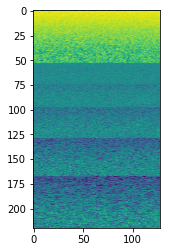

In [8]:
plt.imshow(S_stacked[:,:,0,0])

In [9]:
S_table, _ = format_scat(S_log_renorm, format_type = 'table')
print(S_table.shape)

(220, 128, 1, 40)


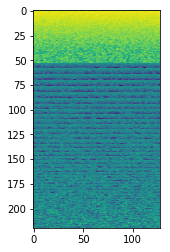

In [10]:
plt.imshow(S_table[:,:,0, 0])

In [95]:
s = np.moveaxis(S_table, [0, 1, 2, 3], [1, 3, 2, 0])
s[-1,:,:,:].shape

(220, 1, 128)

In [94]:
(S_table[:,:,:,0] == s[0]).sum()

28160

In [14]:
a = torch.zeros([64, 1, 1, 100])
b = tensor_to_numpy(a)
c = np.array(b)
a.shape, b.shape, c.shape, torch.FloatTensor(b).shape

(torch.Size([64, 1, 1, 100]),
 (64, 1, 1, 100),
 (64, 1, 1, 100),
 torch.Size([64, 1, 1, 100]))

In [13]:
25*15*32


12000